In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
from scipy import stats
from numpy import mean
import pandas as pd
from pandas import DataFrame

In [3]:

import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Percipitation Analysis

Latest Date: ('2017-08-23',) 
Query Date: 2016-08-23 


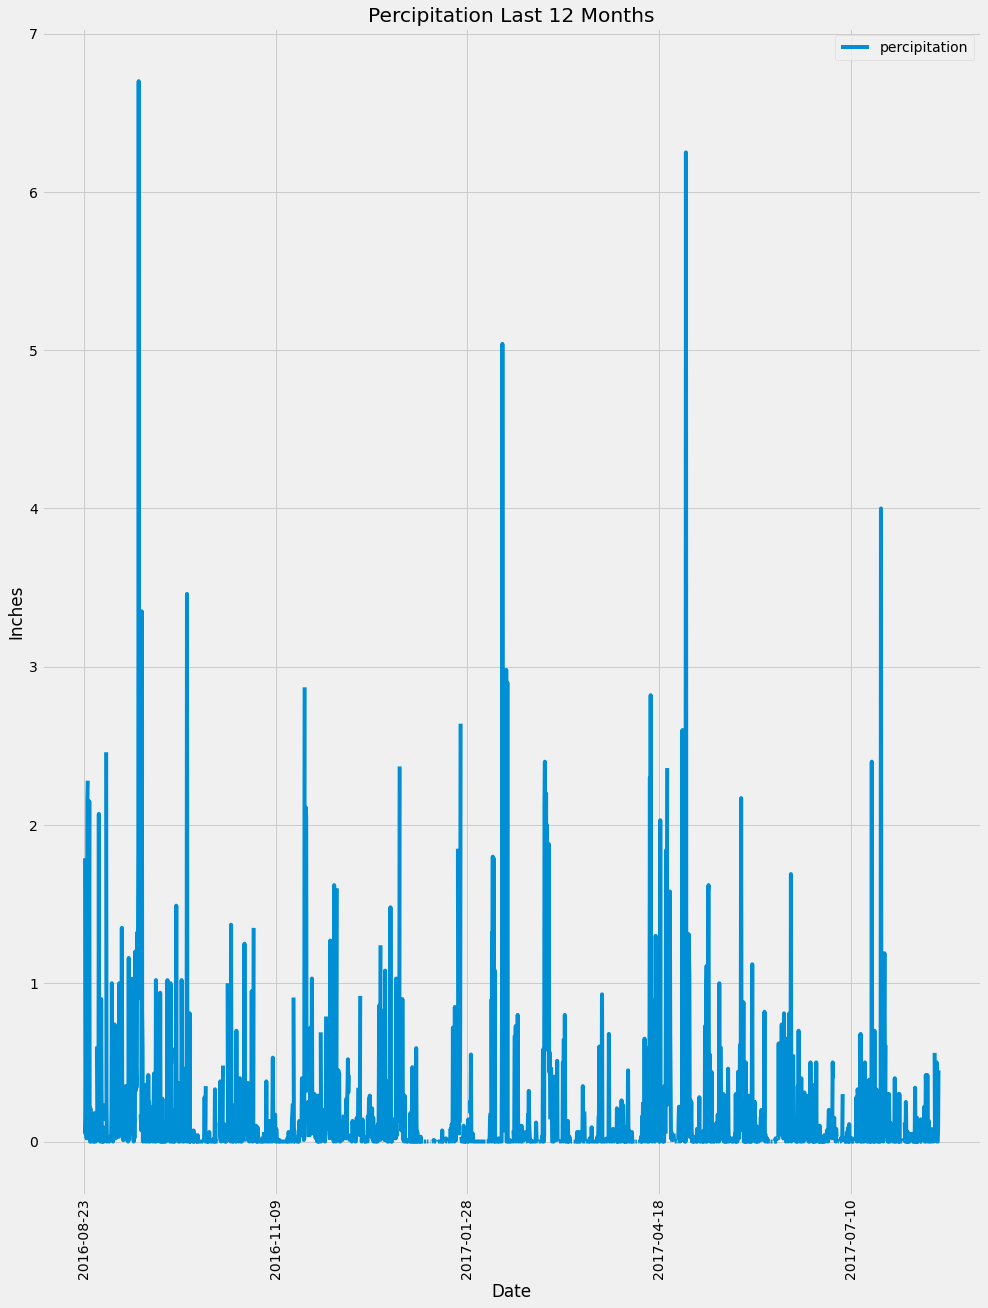

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
latest_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
print(f'Latest Date: {latest_date} ')
# Calculate the date 1 year ago from the last data point in the database
one_year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(f'Query Date: {one_year_ago} ')

# Perform a query to retrieve the data and precipitation scores
query = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
percipitation_df = pd.DataFrame(query, columns=['date', 'percipitation'])
percipitation_df.set_index('date', inplace=True)

# Sort the dataframe by date
percipitation_sorted = percipitation_df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
percipitation_sorted.plot(figsize=(15,20), rot=90, title='Percipitation Last 12 Months')
plt.legend(loc='best')
plt.ylabel('Inches')
plt.xlabel('Date')

# Save Fig
plt.savefig('Images/Percipiation.png')

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
percipitation_df.describe()

,percipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station Analysis

In [12]:
# Design a query to show how many stations are available in this dataset?
available_stations = session.query(measurement.station).distinct().count()
print(f'Stations Available: {available_stations} ')

Stations Available: 9 


In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
most_active = active_stations[0][0]
print(f'The most active station is: {most_active} ')
active_stations

The most active station is: USC00519281 


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded,
# highest temperature recorded, and average temperature of the most active station?
most_active_temps_record = session.query(func.min(measurement.tobs), func.max(measurement.tobs),func.avg(measurement.tobs)).filter(measurement.station == most_active).all()
print(f' The most active station temperature records are: Low: {most_active_temps_record[0][0]} High: {most_active_temps_record[0][1]}, Average: {round(most_active_temps_record[0][2],2)} ')

The most active station temperature records are: Low: 54.0 High: 85.0, Average: 71.66 


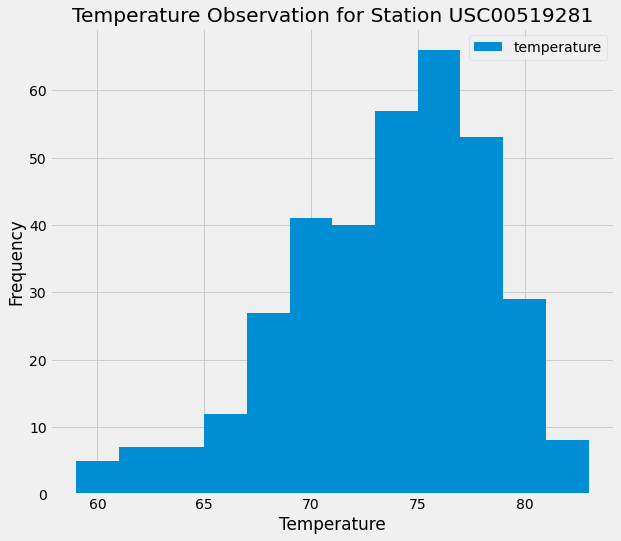

In [15]:
# Choose the station with the highest number of temperature observations.
highest_temps_obs_station = session.query(measurement.station, func.count(measurement.tobs)).group_by(measurement.station).order_by(func.count(measurement.station).desc()).first()
highest_temps_obs_station= highest_temps_obs_station[0]

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_observations = session.query(measurement.tobs).filter(measurement.date >= one_year_ago).filter(measurement.station == highest_temps_obs_station).all()
temperature_observ = pd.DataFrame(temperature_observations, columns=['temperature'])

# Plot histogram
temperature_observ.plot.hist(bins=12, figsize=(9,8))
plt.title('Temperature Observation for Station USC00519281')
plt.xlabel('Temperature')

# Save Figure
plt.savefig('Images/Temperature_Observation_for_Station_USC00519281')

## Bonus - Temperature Analysis I

In [16]:
# Create function to determine the average temperature in june and december per station
def temp_avg(date):
    """temperature average.

    Args:
        date (str): A date in the format '%m'
    
    Returns:
        a List containing the temp_averages per month
    """
    temp = [func.avg(measurement.tobs)]
    return session.query(*temp).group_by(measurement.station).filter(func.strftime("%m", measurement.date) == date).all()

# June average temperatures per station
june_temps_avgs = temp_avg('06')

# December averages per station
dec_temps_avgs = temp_avg('12')

# Create station name and june and december temperatures into a list
june_temps_avg = [74.13939393939394,74.05084745762711,76.00537634408602,71.9372197309417,76.6554054054054,
73.39473684210526,73.27118644067797,77.55932203389831,76.66810344827586]
dec_temps_avg = [69.6842105263158,71.06944444444444,73.2247191011236,69.29126213592232,71.8348623853211,
72.42105263157895,69.90322580645162,71.10952380952381,72.43333333333334]
station_name = ['USC00511918', 'USC00513117', 'USC00514830', 'USC00516128', 'USC00517948', 'USC00518838', 'USC00519281', 'USC00519397', 'USC00519523' ]

# Create Dataframe to store the information
temp_averages = pd.DataFrame({"june_temps_avg": june_temps_avg, "dec_temps_avg":dec_temps_avg, "station": station_name})
temp_averages


,june_temps_avg,dec_temps_avg,station
0,74.139394,69.684211,USC00511918
1,74.050847,71.069444,USC00513117
2,76.005376,73.224719,USC00514830
3,71.937220,69.291262,USC00516128
4,76.655405,71.834862,USC00517948
5,73.394737,72.421053,USC00518838
6,73.271186,69.903226,USC00519281
7,77.559322,71.109524,USC00519397
8,76.668103,72.433333,USC00519523


In [17]:
# Paired t-test or Unpaired/Independent t-test, why?
t, p = stats.ttest_rel(temp_averages['june_temps_avg'], temp_averages['dec_temps_avg'])
t, p

(6.95696617044294, 0.00011759380231523222)

A paired sample t-test was used to conduct this statistical analysis. This is because the June and December average temperatures was compared at the same location (station) or group. The results are deemed statistically significant becuase the p-value<.01.

## Bonus - Temperature Analysis II

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip = calc_temps('2017-01-01', '2018-01-01')
trip

[(58.0, 74.14387974230493, 87.0)]

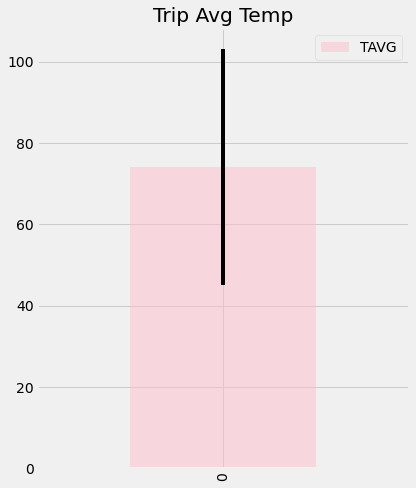

In [20]:
# Plot the results from your previous query as a bar chart. 
# Store values into dataframe to chart
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_df = pd.DataFrame(trip, columns=['TMIN', 'TAVG', 'TMAX'])
trip_df.plot.bar(y='TAVG', yerr=(trip_df['TMAX'] - trip_df['TMIN']), color='pink', alpha=0.5, figsize=(6,7), title='Trip Avg Temp')

# Use "Trip Avg Temp" as your Title
plt.tight_layout()
plt.savefig("Images/Trip_Avg_Temp.png")

## Bonus - Daily Rainfall Average

In [21]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
# Using calc_temps function
def rainfall(start_date, end_date):
    """Precipitation per weather station
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        A list of tuples containing precipitation amount, station, name, latitude, longitude, and elevation in descending order.
    """
    
    data = [measurement.station, 
           station.name, 
           station.latitude, 
           station.longitude, 
           station.elevation, 
           measurement.prcp]
    
    return session.query(*data).\
            filter(measurement.station == station.station).filter(measurement.date >= start_date).filter(measurement.date <= end_date).group_by(measurement.station).order_by(measurement.prcp.desc()).all()

print(rainfall('2017-01-01', '2018-01-01'))

[('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.29), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.03), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.03), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, None), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]


In [22]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [23]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-01-01'
end_date = '2018-01-01'
# Use the start and end date to create a range of dates
trip_dates = pd.date_range(start_date, end_date)

# Strip off the year and save a list of %m-%d strings
date_stripped = trip_dates.strftime('%m-%d')

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for trip_date in date_stripped:
    normals.append(*daily_normals(trip_date))

In [24]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, columns= ['TMIN', 'TAVG', 'TMAX'])
normals_df['Date'] = trip_dates
normals_df = normals_df.set_index('Date')
normals_df

,TMIN,TAVG,TMAX
Date,,,
2017-01-01,62.0,69.153846,77.0
2017-01-02,60.0,69.396226,77.0
2017-01-03,62.0,68.909091,77.0
2017-01-04,58.0,70.000000,76.0
2017-01-05,56.0,67.964286,76.0
...,...,...,...
2017-12-28,62.0,70.520833,77.0
2017-12-29,57.0,70.291667,78.0
2017-12-30,63.0,69.863636,76.0


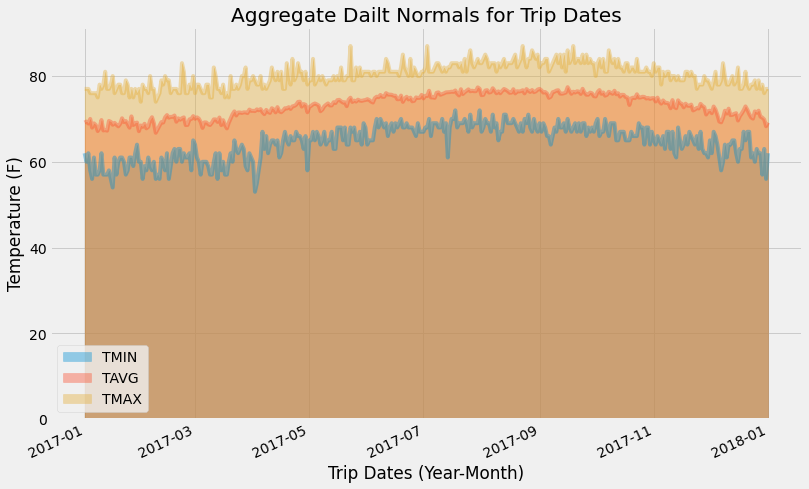

In [25]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot.area(alpha=.4, figsize=(12,8), stacked=False, x_compat=True, title='Aggregate Dailt Normals for Trip Dates', rot=25)

#make the labels
plt.xlabel('Trip Dates (Year-Month)')
plt.ylabel('Temperature (F)')
plt.savefig("Images/Dail_Normals.png")
plt.show()
